In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import convolve1d
import itertools

plt.style.use('ggplot')

   

In [2]:

############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001

# Solve differential equation from time 0 to time T
T = 2

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)




In [3]:
############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# store the solutions
q_all = np.zeros((len(t),freq_bands))
r_all = np.zeros((len(t),freq_bands))




#define the kernels (assuming that they fold over 16 freq_bands)
# x =  np.linspace(0,freq_bands,freq_bands)
# cf = 8



In [4]:
############################################################
#                       Functions                          #
############################################################

#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a,b):
    a = 20 
    b = 0.25
    # build a threshold
    r_bpc[r_bpc < 0.09] = 0.0
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    ## Defines a threshold ?
    # q_pc[q_pc < 0.001] = 0.0
    q_pc[q_pc < 0.0025] = 0.0
    return np.maximum(q_pc,0)
#     return 1 / (1 + np.exp(-(q_pc-0.5)*8) )
# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,bias):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel))
            
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - (gamma_r + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
    return tau_r * d_r_bpc


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return tau_q * d_q_pc


## LSO Neuron Response Test

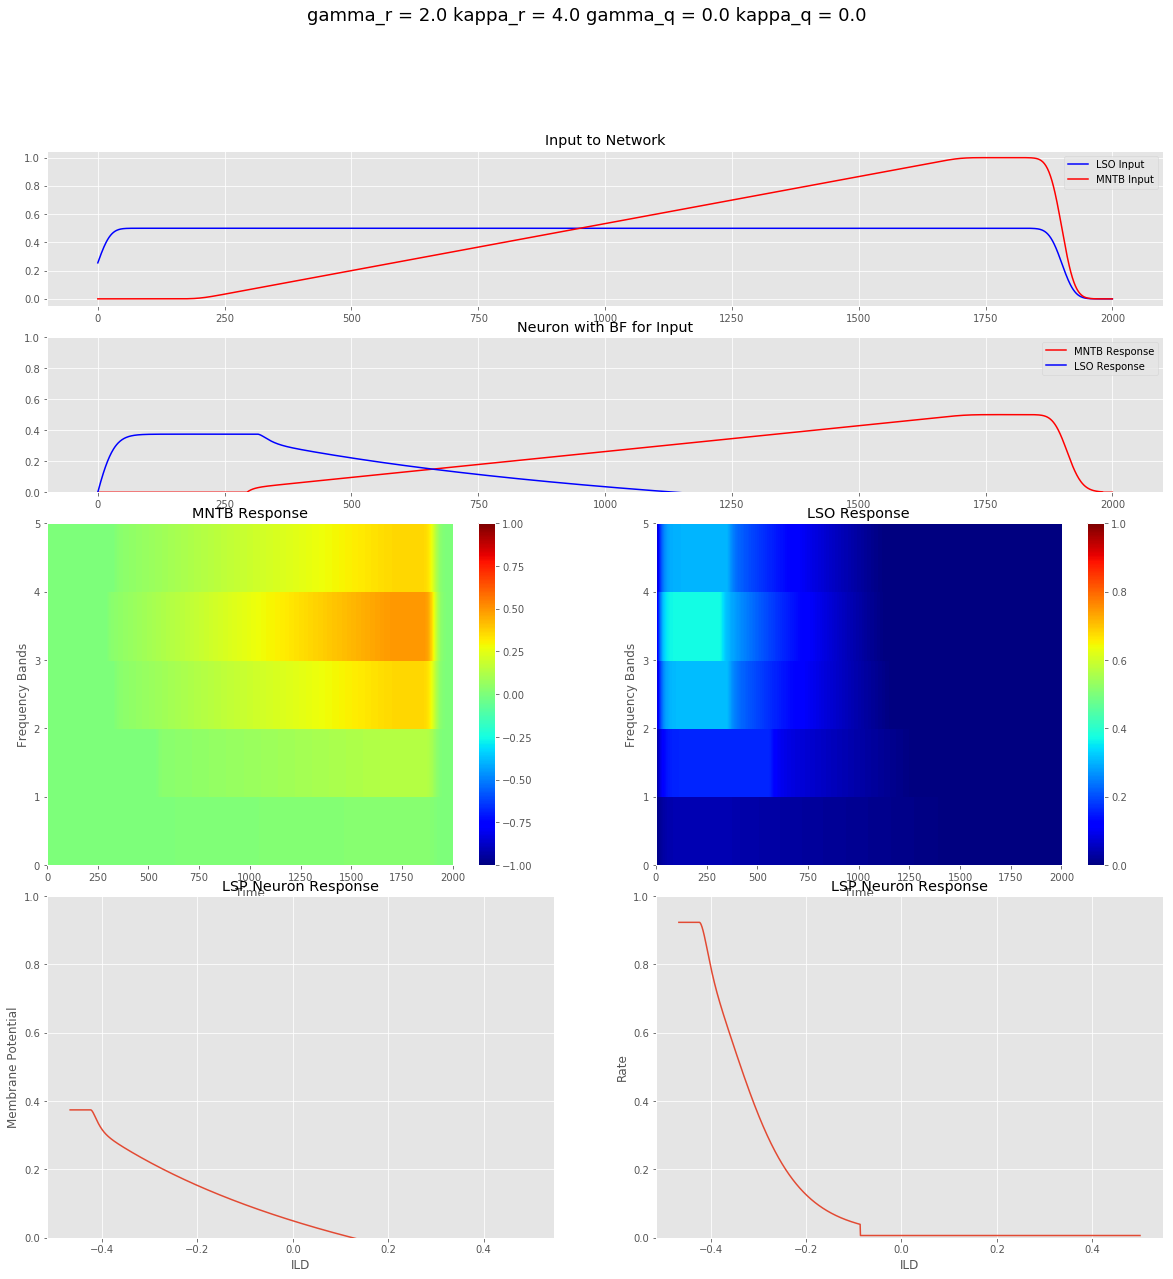

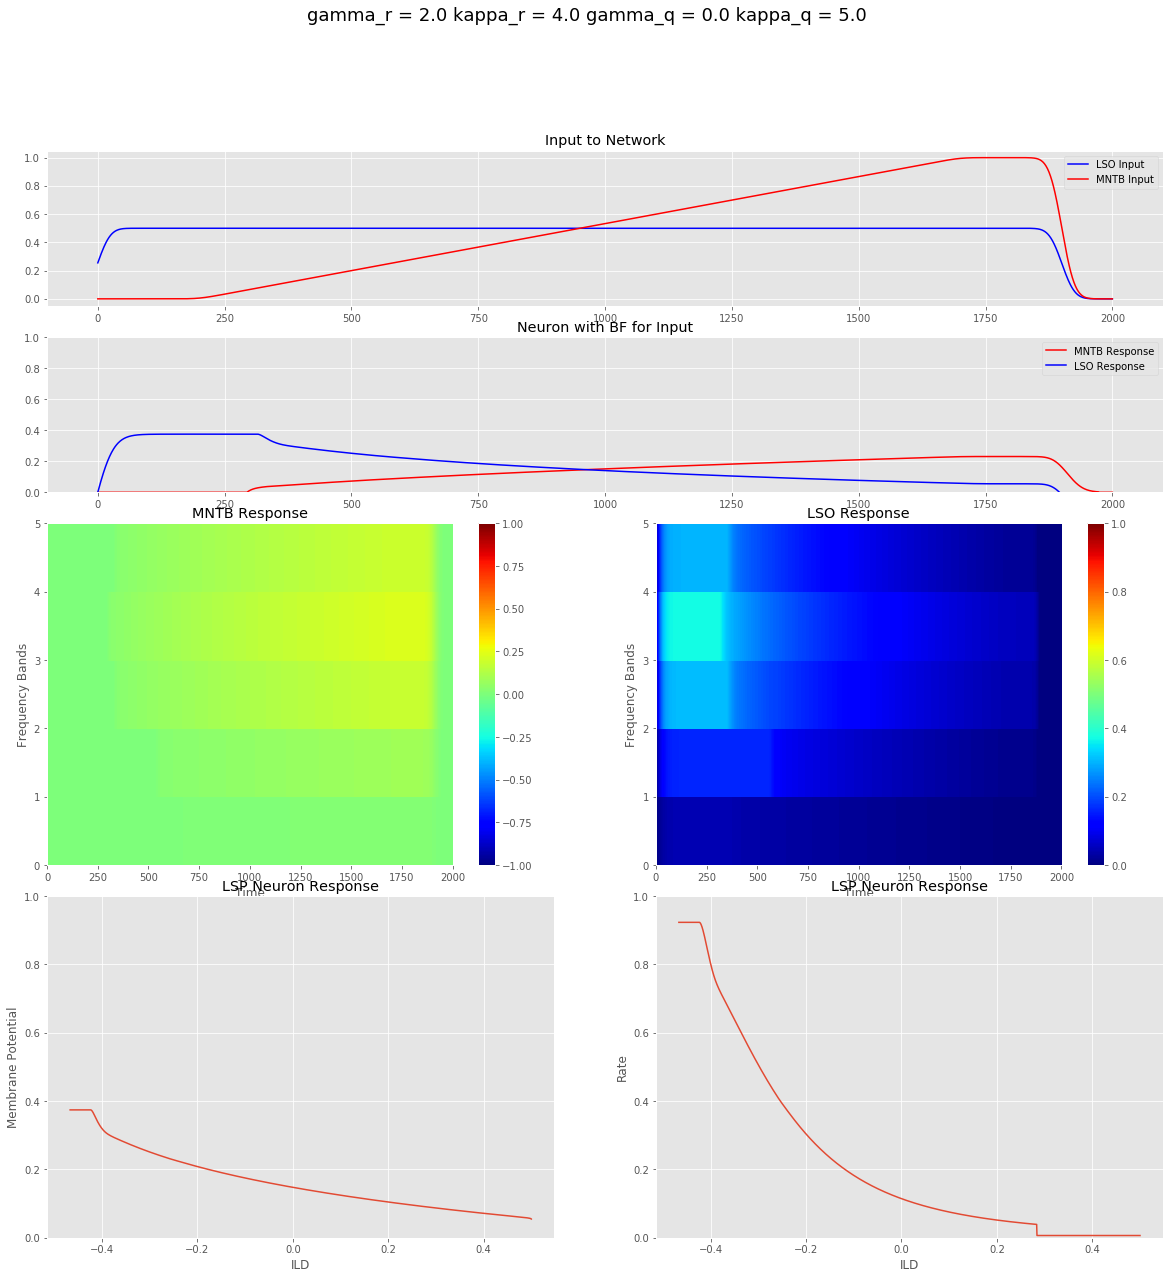

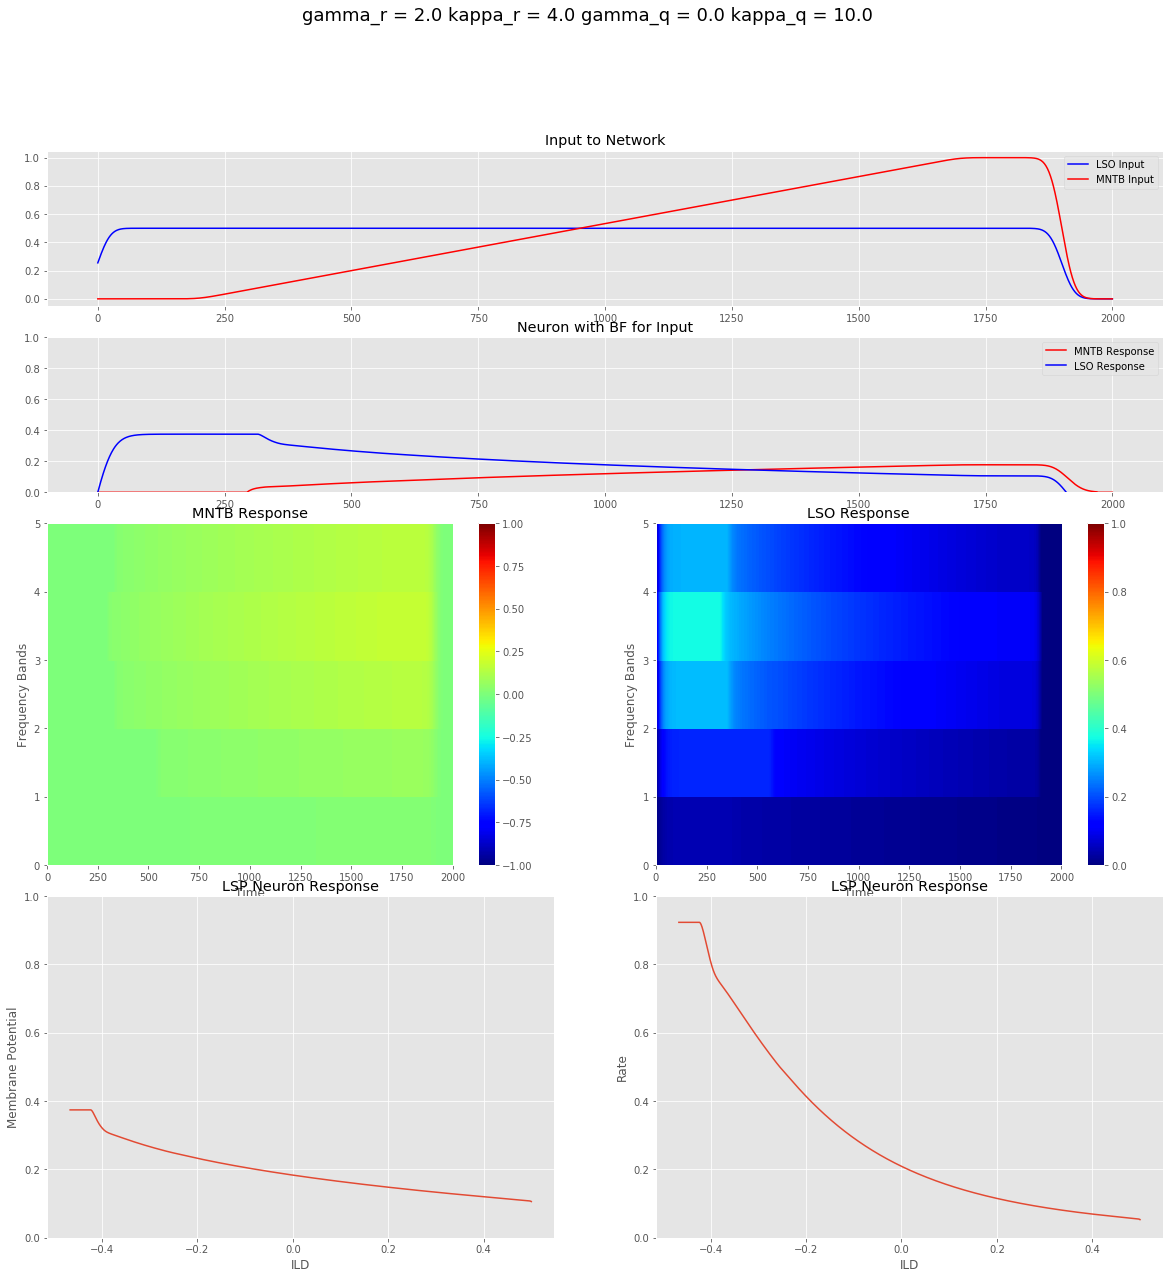

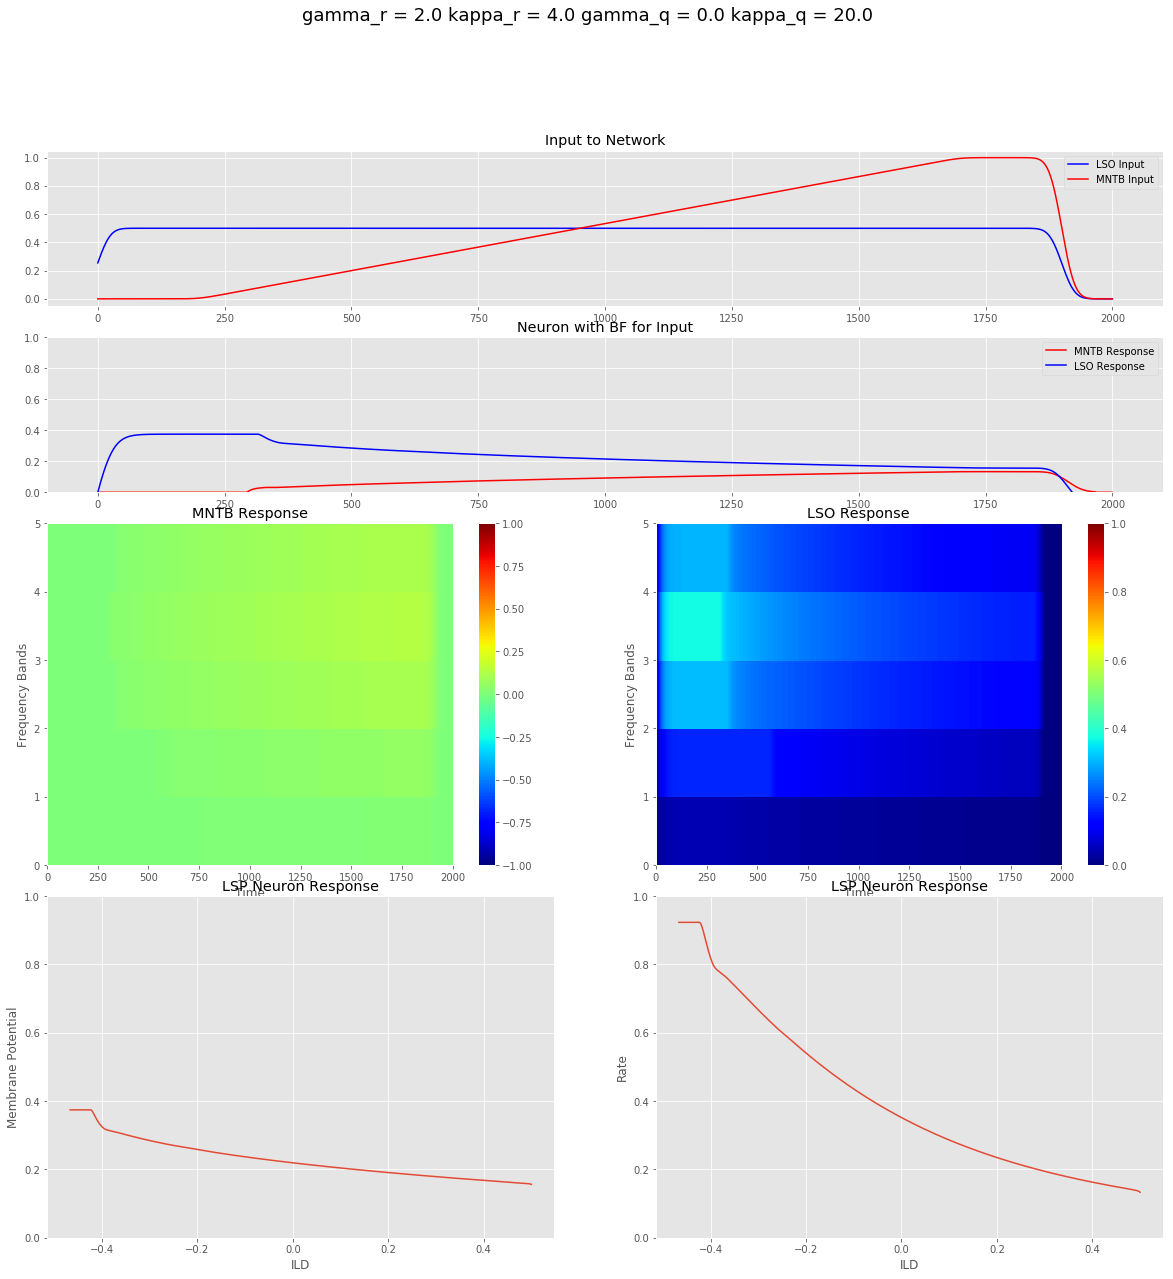

In [16]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.25

# MNTB inhibitory input (contra-lateral)
gbc_input_onset = 200
gbc_input_duration = 500
gbc_center_frequencyBand =3
gbc_input_strength = 2.0
# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
# build a plateau at the end to let the neurons go to a steady state
s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
# create the decreasing function
dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
# add axis so that we acutally have array of (n,m) and not just (n,)
gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
dec_func = dec_func[np.newaxis]
s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


# LSO direct excitatory input (ipsi-lateral)
sbc_input_onset = 100
sbc_input_duration = 500
sbc_center_frequencyBand = 3
sbc_input_strength = 1.0
sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
# build a plateau at the beginning to let the neurons go to a steady state
s_sbc_all[sbc_input_onset-100:sbc_input_onset] = 1 * sbc_input_strength * sbc_gauss_mask
s_sbc_all[sbc_input_onset:-100] = sbc_gauss_mask * sbc_input_strength



# Convolve with gauss curve to build a temporal ramp
s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
s_gbc_all /= maxi
s_sbc_all /= maxi



############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

delay_factor = 20


# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[0,:] = 0.0


############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
#for gamma_r,kappa_r,gamma_q,kappa_q in zip([0.0,2.0,2.0],[30.0,0.0,4.0],[1.0,1.0,0.0],[1.0,0.0,0.0]):
for gamma_r,kappa_r,gamma_q,kappa_q in zip([2.0,2.0,2.0,2.0],[4.0,4.0,4.0,4.0],[0.0,0.0,0.0,0.0],[0.0,5.0,10.0,20.0]):
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):

            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
                
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[i+1,w] = r_all[i,w] +  dt * ode_r_bpc(r_all[i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape),ei_kernel,spf_r)       
            else:
                r_all[i+1,w] = r_all[i,w] +  dt * ode_r_bpc(r_all[i,w],s_sbc_all[i],ee_kernel,q_all[i-delay_factor,:],ei_kernel,spf_r)       
                
            q_all[i+1,w] = q_all[i,w] +  dt * ode_q_pc(q_all[i,w],s_gbc_all[i],ie_kernel,q_all[i,:],ii_kernel)






    ############################################################
    #                       Plotting                           #
    ############################################################

    fig = plt.figure(figsize=(20,20))
    ax1 = plt.subplot2grid((6, 2), (0, 0), colspan=2)
    plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
    plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
    plt.title('Input to Network')
    plt.legend()


    stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
    plt.suptitle(stri,fontsize=18)
    ax1 = plt.subplot2grid((6, 2), (1, 0), colspan=2)
    plt.plot(q_all[:,3],'red',  label='MNTB Response')
    plt.plot(r_all[:,3],'blue', label='LSO Response')
    plt.title('Neuron with BF for Input')
    plt.ylim([0,1])
    plt.legend()


    ax2 = plt.subplot2grid((6, 2), (2, 0), rowspan=2)
    ax = plt.pcolor(q_all.T,cmap='jet',vmin=-1., vmax=1.)
    plt.title('MNTB Response')
    plt.xlabel('Time')
    plt.ylabel('Frequency Bands')
    plt.colorbar()


    ax2 = plt.subplot2grid((6, 2), (2, 1), rowspan=2)
    ax = plt.pcolor(r_all.T,cmap='jet',vmin=0., vmax=1.)
    plt.title('LSO Response')
    plt.xlabel('Time')
    plt.ylabel('Frequency Bands')
    plt.colorbar()

    # show LSO neuron membrane
    diff_input =  s_gbc_all-s_sbc_all
    diff_input = diff_input[250:1750,3]
    r = r_all[250:1750,3]
    ax2 = plt.subplot2grid((6, 2), (4, 0), rowspan=2)
    plt.plot(diff_input,r)
    plt.title('LSP Neuron Response')
    plt.xlabel('ILD')
    plt.ylabel('Membrane Potential')
    plt.ylim([0,1])
    
    # show LSO neuron response
    ax2 = plt.subplot2grid((6, 2), (4, 1), rowspan=2)
    plt.plot(diff_input,g_r_out(r,60,np.mean(r)))
    plt.title('LSP Neuron Response')
    plt.xlabel('ILD')
    plt.ylabel('Rate')
    plt.ylim([0,1])

    
    plt.show()

